In [9]:
# prompt: Rewrite entire Neural Network code with plotting accuracy, loss and examples

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

class NeuralNetwork:
    def __init__(self, layer_dims, learning_rate=0.01, epochs=1000):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.parameters = self.init_params(layer_dims)
        self.cost_history = []

    def init_params(self, layer_dims):
        np.random.seed(3)
        params = {}
        L = len(layer_dims)

        for l in range(1, L):
            params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2./layer_dims[l-1]) # He initialization
            params['b' + str(l)] = np.zeros((layer_dims[l], 1))

        return params

    def sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z
        return A, cache

    def forward_prop(self, X, params):
        A = X
        caches = []
        L = len(params) // 2
        for l in range(1, L + 1):
            A_prev = A
            Z = np.dot(params['W' + str(l)], A_prev) + params['b' + str(l)]
            linear_cache = (A_prev, params['W' + str(l)], params['b' + str(l)])
            A, activation_cache = self.sigmoid(Z)
            cache = (linear_cache, activation_cache)
            caches.append(cache)
        return A, caches

    # Modified cost function for multi-class cross-entropy with one-hot encoding
    def cost_function(self, A, Y):
        m = Y.shape[1]
        # Avoid log(0) by clipping values
        A = np.clip(A, 1e-10, 1 - 1e-10)
        # Multi-class cross-entropy cost
        cost = (-1 / m) * np.sum(Y * np.log(A))
        # Ensure cost is a scalar (should be after sum)
        return cost

    def one_layer_backward(self, dA, cache):
        linear_cache, activation_cache = cache

        Z = activation_cache
        s = 1 / (1 + np.exp(-Z)) # Sigmoid(Z)
        dZ = dA * s * (1 - s)

        A_prev, W, b = linear_cache
        m = A_prev.shape[1]

        dW = (1 / m) * np.dot(dZ, A_prev.T)
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db

    def backprop(self, AL, Y, caches):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        # Y is already the same shape as AL (num_classes, m) due to one-hot encoding

        # Initial gradient for the output layer
        # Avoid division by zero
        AL = np.clip(AL, 1e-10, 1 - 1e-10)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        current_cache = caches[L - 1]
        # Note: The derivative dA from the one_layer_backward becomes the input dA for the previous layer.
        # The dW and db calculated in one_layer_backward are for the current layer (L).
        grads['dA' + str(L - 1)], grads['dW' + str(L)], grads['db' + str(L)] = self.one_layer_backward(dAL, current_cache)

        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.one_layer_backward(grads["dA" + str(l + 1)], current_cache)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads

    def update_parameters(self, parameters, grads, learning_rate):
        L = len(parameters) // 2

        for l in range(L):
            parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
            parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]

        return parameters

    def train(self, X, Y, X_test=None, Y_test=None, plot_interval=100):
        self.cost_history = []
        self.train_accuracy_history = []
        self.test_accuracy_history = []
        self.epochs_list = [] # To store epochs where accuracy was recorded

        for i in range(self.epochs):
            Y_hat, caches = self.forward_prop(X, self.parameters)
            cost = self.cost_function(Y_hat, Y)
            self.cost_history.append(cost)

            # Calculate and store accuracy periodically
            if i % plot_interval == 0 or i == self.epochs - 1:
                train_accuracy = self.evaluate(X, Y)
                self.train_accuracy_history.append(train_accuracy)
                self.epochs_list.append(i) # Record the epoch number

                if X_test is not None and Y_test is not None:
                    test_accuracy = self.evaluate(X_test, Y_test)
                    self.test_accuracy_history.append(test_accuracy)

                print(f"Epoch {i}: Cost = {cost:.4f}, Train Accuracy = {train_accuracy:.2f}%")
                if X_test is not None and Y_test is not None:
                    print(f"Test Accuracy = {test_accuracy:.2f}%")


            grads = self.backprop(Y_hat, Y, caches)
            self.parameters = self.update_parameters(self.parameters, grads, self.learning_rate)

            print("Training finished.")

    def predict(self, X):
        """
        This function is used to predict the results of a L-layer neural network.

        Arguments:
        X -- data set of examples you would like to predict

        Returns:
        predictions -- predictions for the given dataset X
        """
        AL, caches = self.forward_prop(X, self.parameters)
        # For multi-class classification with one-hot encoded labels and sigmoid output per class,
        # we predict the class with the highest activation.
        predictions_one_hot = (AL == np.max(AL, axis=0, keepdims=True)).astype(int)

        return predictions_one_hot # Return in one-hot format to match Y_one_hot shape for evaluation

    def evaluate(self, X, Y):
        """
        Evaluates the accuracy of the neural network.

        Arguments:
        X -- dataset of examples
        Y -- true labels (one-hot encoded)

        Returns:
        accuracy -- accuracy of the predictions
        """
        predictions = self.predict(X)
        # Compare the predicted one-hot vectors with the true one-hot vectors.
        # np.all(predictions == Y, axis=0) checks if each column (example) is predicted correctly.
        correct_predictions = np.sum(np.all(predictions == Y, axis=0))
        accuracy = (correct_predictions / Y.shape[1]) * 100
        return accuracy

In [10]:

# --- Data Preparation (Iris) ---
iris_data = load_iris()
X_iris, y_iris = iris_data.data.T, iris_data.target.reshape(1, -1)

def one_hot_encode(Y, num_classes):
    m = Y.shape[1]
    one_hot = np.zeros((num_classes, m))
    for i in range(m):
        one_hot[Y[0, i], i] = 1
    return one_hot

num_classes_iris = len(np.unique(y_iris))
Y_iris_one_hot = one_hot_encode(y_iris, num_classes_iris)

X_train_iris, X_test_iris, Y_train_oh_iris, Y_test_oh_iris = train_test_split(
    X_iris.T, Y_iris_one_hot.T, test_size=0.20, random_state=42
)

X_train_iris = X_train_iris.T
X_test_iris = X_test_iris.T
Y_train_oh_iris = Y_train_oh_iris.T
Y_test_oh_iris = Y_test_oh_iris.T

In [11]:
# Define layer dimensions for Iris
layer_dims_iris = [X_train_iris.shape[0], 10, 5, num_classes_iris]

In [12]:
# --- Train and Plot for Iris ---
print("\n--- Training on Iris Dataset ---")
nn_iris = NeuralNetwork(layer_dims_iris, learning_rate=1, epochs=2000)


--- Training on Iris Dataset ---


In [13]:
nn_iris.train(X_train_iris, Y_train_oh_iris, X_test_iris, Y_test_oh_iris, plot_interval=100)

Epoch 0: Cost = 0.8131, Train Accuracy = 62.50%
Test Accuracy = 66.67%
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished

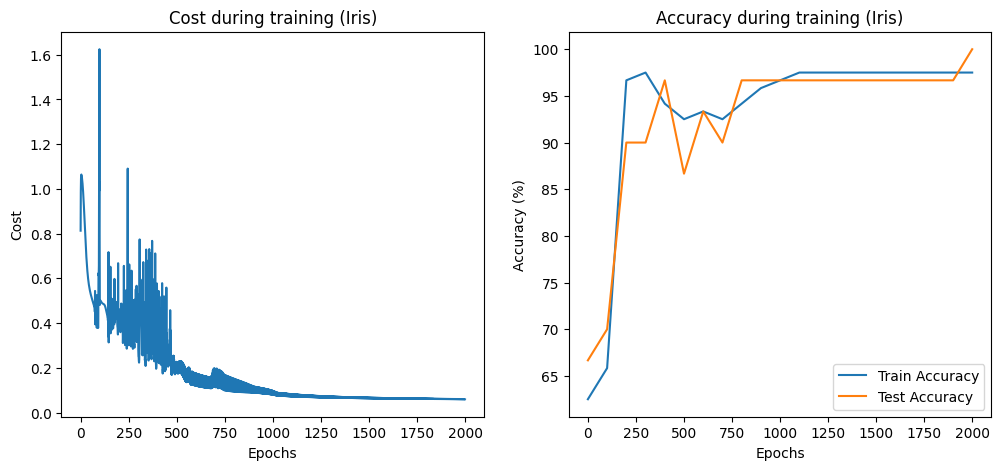

In [14]:
# Plot the cost history for Iris
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nn_iris.cost_history)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost during training (Iris)")

# Plot the accuracy history for Iris
plt.subplot(1, 2, 2)
plt.plot(nn_iris.epochs_list, nn_iris.train_accuracy_history, label='Train Accuracy')
if nn_iris.test_accuracy_history:
    plt.plot(nn_iris.epochs_list, nn_iris.test_accuracy_history, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy during training (Iris)")
plt.legend()
plt.show()

In [15]:

# --- Test network by evaluating single examples from Iris test set ---
print("\n--- Evaluating Single Examples from Iris Test Set ---")

# Helper function to test a single Iris example
def test_single_example_iris(X_example, parameters, true_label_one_hot, class_names):
    """
    Tests the neural network on a single Iris example and prints the prediction.
    """
    AL, _ = nn_iris.forward_prop(X_example, parameters) # Use nn_iris's forward_prop
    prediction_one_hot = (AL == np.max(AL, axis=0, keepdims=True)).astype(int)

    predicted_class_index = np.argmax(prediction_one_hot)
    true_class_index = np.argmax(true_label_one_hot)

    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print(f"\n--- Testing Single Iris Example ---")
    print(f"Predicted class: {predicted_class_name}")
    print(f"True class: {true_class_name}")

    if predicted_class_index == true_class_index:
        print("Prediction: Correct")
    else:
        print("Prediction: Incorrect")

# Test a few examples from the Iris test set
test_indices_iris = [0, 5, 10, 15] # Example indices
class_names_iris = iris_data.target_names

for idx in test_indices_iris:
    if idx < X_test_iris.shape[1]:
        X_example_iris = X_test_iris[:, idx].reshape(-1, 1)
        Y_example_oh_iris = Y_test_oh_iris[:, idx].reshape(-1, 1)
        test_single_example_iris(X_example_iris, nn_iris.parameters, Y_example_oh_iris, class_names_iris)
    else:
        print(f"Index {idx} is out of bounds for the Iris test set (size {X_test_iris.shape[1]}). Skipping.")



--- Evaluating Single Examples from Iris Test Set ---

--- Testing Single Iris Example ---
Predicted class: versicolor
True class: versicolor
Prediction: Correct

--- Testing Single Iris Example ---
Predicted class: setosa
True class: setosa
Prediction: Correct

--- Testing Single Iris Example ---
Predicted class: virginica
True class: virginica
Prediction: Correct

--- Testing Single Iris Example ---
Predicted class: versicolor
True class: versicolor
Prediction: Correct


In [17]:

# --- Data Preparation (MNIST) ---
print("\n--- Preparing MNIST Dataset ---")
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], -1).T / 255.0
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], -1).T / 255.0

def one_hot_encode_mnist(Y, num_classes=10):
    m = Y.shape[0]
    one_hot = np.zeros((num_classes, m))
    for i in range(m):
        one_hot[Y[i], i] = 1
    return one_hot



--- Preparing MNIST Dataset ---
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
x_train_mnist[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [18]:

num_classes_mnist = 10
y_train_oh_mnist = one_hot_encode_mnist(y_train_mnist)
y_test_oh_mnist = one_hot_encode_mnist(y_test_mnist)

In [19]:
# Define layer dimensions for MNIST
layer_dims_mnist = [x_train_mnist.shape[0], 128, 64, num_classes_mnist]

In [ ]:
# --- Train and Plot for MNIST ---
print("\n--- Training on MNIST Dataset ---")
nn_mnist = NeuralNetwork(layer_dims_mnist, learning_rate=0.5, epochs=1000)
nn_mnist.train(x_train_mnist, y_train_oh_mnist, x_test_mnist, y_test_oh_mnist, plot_interval=100)

# Plot the cost history for MNIST
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nn_mnist.cost_history)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost during training (MNIST)")

# Plot the accuracy history for MNIST
plt.subplot(1, 2, 2)
plt.plot(nn_mnist.epochs_list, nn_mnist.train_accuracy_history, label='Train Accuracy')
if nn_mnist.test_accuracy_history:
    plt.plot(nn_mnist.epochs_list, nn_mnist.test_accuracy_history, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy during training (MNIST)")
plt.legend()
plt.show()


--- Training on MNIST Dataset ---
Epoch 0: Cost = 0.7868, Train Accuracy = 11.24%
Test Accuracy = 11.35%
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
T

In [ ]:
# --- Test network by evaluating single examples from MNIST test set ---
print("\n--- Evaluating Single Examples from MNIST Test Set ---")

# Helper function to display an MNIST image and its prediction
def display_mnist_prediction(image_vector, true_label_int, predicted_label_int):
    image = image_vector.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label_int}, Predicted: {predicted_label_int}")
    plt.axis('off')
    plt.show()

# Test a few random examples from the MNIST test set
num_test_examples_mnist = 5
random_indices_mnist = np.random.choice(x_test_mnist.shape[1], num_test_examples_mnist, replace=False)

for idx in random_indices_mnist:
    x_example_mnist = x_test_mnist[:, idx].reshape(-1, 1)
    y_example_oh_mnist = y_test_oh_mnist[:, idx].reshape(-1, 1)

    AL, _ = nn_mnist.forward_prop(x_example_mnist, nn_mnist.parameters)
    predicted_one_hot = (AL == np.max(AL, axis=0, keepdims=True)).astype(int)

    predicted_label_int = np.argmax(predicted_one_hot)
    true_label_int = np.argmax(y_example_oh_mnist)

    print(f"Example index: {idx}, True Label: {true_label_int}, Predicted Label: {predicted_label_int}")
    display_mnist_prediction(x_test_mnist[:, idx], true_label_int, predicted_label_int)


In [ ]:
# prompt: Compute the number of parameters and save model architecture and weights

import numpy as np
import pickle

# Assuming `nn_mnist` is your trained NeuralNetworkWithPlots object
# You can save the parameters (weights and biases)
model_weights = nn_mnist.parameters

# Define filenames for saving
architecture_filename = "model_architecture.txt"
weights_filename = "model_weights.pkl"

# Compute number of parameters
num_params = 0
for layer in nn_mnist.parameters:
    if layer.startswith('W'):
        num_params += np.prod(nn_mnist.parameters[layer].shape)
    elif layer.startswith('b'):
         num_params += np.prod(nn_mnist.parameters[layer].shape)

print(f"Total number of parameters: {int(num_params)}")


# Save the model architecture (layer dimensions)
architecture_info = {
    "layer_dims": nn_mnist.layer_dims,
    "learning_rate": nn_mnist.learning_rate,
    "epochs": nn_mnist.epochs
    # Add any other relevant architecture details
}
with open(architecture_filename, 'w') as f:
    import json
    json.dump(architecture_info, f, indent=2)

print(f"Model architecture saved to {architecture_filename}")

# Save the model weights using pickle
with open(weights_filename, 'wb') as f:
    pickle.dump(model_weights, f)

print(f"Model weights saved to {weights_filename}")

# Example of how to load the weights later
# with open(weights_filename, 'rb') as f:
#     loaded_weights = pickle.load(f)

# Example of how to load the architecture later
# with open(architecture_filename, 'r') as f:
#     loaded_architecture = json.load(f)

# Example of how to reconstruct the model with loaded weights
# loaded_layer_dims = loaded_architecture["layer_dims"]
# loaded_nn = NeuralNetwork(loaded_layer_dims) # Or NeuralNetworkWithPlots if preferred
# loaded_nn.parameters = loaded_weights

# You can then use loaded_nn for prediction or further training


# Save model architecture and weights for the Iris model as well
# Assuming `nn_iris` is your trained Iris model
model_weights_iris = nn_iris.parameters

architecture_filename_iris = "model_architecture_iris.txt"
weights_filename_iris = "model_weights_iris.pkl"

# Compute number of parameters for Iris model
num_params_iris = 0
for layer in nn_iris.parameters:
    if layer.startswith('W'):
        num_params_iris += np.prod(nn_iris.parameters[layer].shape)
    elif layer.startswith('b'):
         num_params_iris += np.prod(nn_iris.parameters[layer].shape)

print(f"\nTotal number of parameters for Iris model: {int(num_params_iris)}")

# Save Iris model architecture
architecture_info_iris = {
    "layer_dims": nn_iris.layer_dims,
    "learning_rate": nn_iris.learning_rate,
    "epochs": nn_iris.epochs
}
with open(architecture_filename_iris, 'w') as f:
    import json
    json.dump(architecture_info_iris, f, indent=2)

print(f"Iris model architecture saved to {architecture_filename_iris}")

# Save Iris model weights
with open(weights_filename_iris, 'wb') as f:
    pickle.dump(model_weights_iris, f)

print(f"Iris model weights saved to {weights_filename_iris}")

Total number of parameters: 109386
Model architecture saved to model_architecture.txt
Model weights saved to model_weights.pkl

Total number of parameters for Iris model: 123
Iris model architecture saved to model_architecture_iris.txt
Iris model weights saved to model_weights_iris.pkl
